<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W3D3/tutorials/W3D3_NetworkCausality/W3D3_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy 2020 -- Week 3 Day 3, Tutorial 2

# Causality Day: Correlations


# Tutorial objectives

This is tutorial 2 on our day of examining causality. Below is the high level outline of what we'll cover today, with the sections we will focus on in this tutorial in bold:

1.   **Master definitions of causality**
2.   **Understand that estimating causality is possible**
3.   Learn 5 different methods and understand when they fail
    1. perturbations
    2. **correlations**
    3. simultaneous fitting/regression
    4. Granger causality
    5. instrumental variables

### Tutorial 2 objectives

In tutorial 1, we implemented and explored the dynamical system of neurons we will be working with throughout all of the tutorials today. We also learned about the "gold standard" of measuring causal effects through random perturbations. As random perturbations are often not possible, we will now turn to alternative methods to attempt to measure causality. We will:

- Learn how to estimate connectivity from observations assuming **correlations approximate causation**
- Show that this only works when the network is small

### Tutorial 2 setting

Often, we can't force neural activites or brain areas to be on or off. We just have to observe. Maybe we can get the correlation between two nodes -- is that good enough? The question we ask in this tutorial is **when is correlation a "good enough" substitute for causation?**

The answer is not "never", actually, but "sometimes". Ask yourself, though, if in typical neuroscience situations this is ever going to be the case.




# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet, Lasso
from statsmodels.tsa.stattools import grangercausalitytests


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#@title Figure Settings
%matplotlib inline
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'

In [3]:
# @title Helper functions
def sigmoid(x):
    """
    Compute sigmoid nonlinearity element-wise on x.
    
    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with sigmoid nonlinearity applied
    """
    return 1 / (1 + np.exp(-x))


def logit(x):
    """
    
    Applies the logit (inverse sigmoid) transformation
    
    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with logit nonlinearity applied
    """
    return np.log(x/(1-x))

def create_connectivity(n_neurons, random_state=42):
    """
    Generate our nxn causal connectivity matrix.

    Args:
        n_neurons (int): the number of neurons in our system.
        random_state (int): random seed for reproducibility

    Returns:
        A (np.ndarray): our 0.1 sparse connectivity matrix
    """
    np.random.seed(random_state)
    A_0 = np.random.choice([0,1], size=(n_neurons, n_neurons), p=[0.9, 0.1])

    # set the timescale of the dynamical system to about 100 steps
    _, s_vals , _ = np.linalg.svd(A_0)
    A = A_0 / (1.01 * s_vals[0]) 

    # _, s_val_test, _ = np.linalg.svd(A)
    # assert s_val_test[0] < 1, "largest singular value >= 1"

    return A

def see_neurons(A, ax):
    """
    Visualizes the connectivity matrix.

    Args:
        A (np.ndarray): the connectivity matrix of shape (n_neurons, n_neurons)
        ax (plt.axis): the matplotlib axis to display on

    Returns:
        Nothing, but visualizes A.
    """
    n = len(A)
    ax.set_aspect('equal')
    thetas = np.linspace(0,np.pi*2,n,endpoint=False )
    x,y = np.cos(thetas),np.sin(thetas),
    ax.scatter(x,y,c='k',s=150)
    A = A/A.max()
    for i in range(n):
        for j in range(n):
            if A[i,j]>0:
                ax.arrow(x[i],y[i],x[j]-x[i],y[j]-y[i],color='k',alpha=A[i,j],head_width=.15,
                        width = A[i,j]/25,shape='right', length_includes_head=True)
    ax.axis('off')

def simulate_neurons(A, timesteps, random_state=42):
    """
    Simulates a dynamical system for the specified number of neurons and timesteps.

    Args:
        A (np.array): the connectivity matrix
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): random seed for reproducibility
        
    Returns:
        - X has shape (n_neurons, timeteps).
    """
    np.random.seed(random_state)

    
    n_neurons = len(A)
    X = np.zeros((n_neurons, timesteps))

    for t in range(timesteps-1):
        # solution
        epsilon = np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons))
        X[:, t+1] = sigmoid(A.dot(X[:,t]) + epsilon)

        assert epsilon.shape == (n_neurons,)
    return X

def get_sys_corr(n_neurons, timesteps, random_state=42, neuron_idx=None):
    """
    A wrapper function for our correlation calculations between A and R.

    Args:
        n_neurons (int): the number of neurons in our system.
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): seed for reproducibility
        neuron_idx (int): optionally provide a neuron idx to slice out

    Returns:
        A single float correlation value representing the similarity between A and R
    """
    
    A = create_connectivity(n_neurons,random_state)
    X = simulate_neurons(A, timesteps)

    R = correlation_for_all_neurons(X)

    return np.corrcoef(A.flatten(), R.flatten())[0,1]


def plot_estimation_quality_vs_n_neurons(number_of_neurons):
    """
    A wrapper function that calculates correlation between true and estimated connectivity
    matrices for each number of neurons and plots

    Args:
      number_of_neurons (list): list of different number of neurons for modeling system

    """ 
    
    df_dict = {
     'trial': [],
     'n_neurons': [],
     'corr': []
     }

    for trial in range(n_trials):
        print("simulating trial {} of {}".format(trial+1, n_trials))
        for size in number_of_neurons:
            corr = get_sys_corr(size, timesteps, trial)
            df_dict['trial'].append(trial)
            df_dict['n_neurons'].append(size)
            df_dict['corr'].append(corr)


    corr_df = pd.DataFrame.from_dict(df_dict)

    sns.lineplot(x="n_neurons", y="corr", data=corr_df)
    plt.title("Similarity between A and R as a function of network size")
    plt.show()

# Small systems



Video available at https://youtu.be/30je33NZdvE


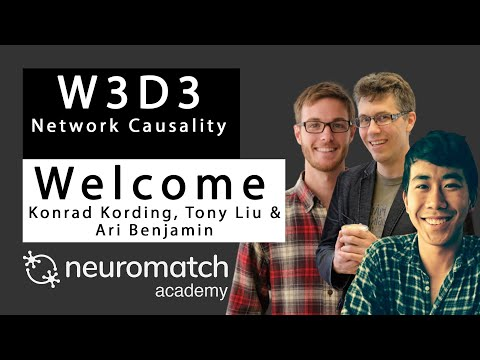

In [4]:
#@title Video 
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="30je33NZdvE", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Exercise 1: Try to approximate causation with correlation

In small systems, correlation can look like causation. Let's attempt to recover the true connectivity matrix (A) just by correlating the neural state at each timestep with the previous state: $C=\vec{x_t}{\vec{x_{t+1}}^t}$. 

Complete this function to estimate the connectivity matrix of a single neuron by calculating the correlation coefficients with every other neuron. In particular, we will correlate two vectors: 1) the activities of all neurons, 2) the activity of a selected neuron at the next time step. 

In [5]:
def compute_connectivity_single_neuron(X, selected_neuron):
    """
    Computes the connectivity matrix for a single neuron neurons using correlations

    Args:
        X (ndarray): the matrix of activities
        selected_neuron (int): the index of the selected neuron

    Returns:
        estimated_connectivity (ndarray): estimated connectivity for the selected neuron, of shape (n_neurons,)
    """

    next_activity = X[selected_neuron, 1:] # extract the next activities of a neuron, t+1
    current_activity = X[:, :-1] # extract the current activity, t

    estimated_connectivity = np.zeros(n_neurons) # our stored estimated connectivity matrix

    # Loop through all neurons
    for neuron_idx in range(n_neurons):

        # Get the activity of neuron_idx
        this_input_activity = current_activity[neuron_idx]

        ########################################################################
        ## TODO: Estimate the neural correlations between
        ## this_input_activity        and       current_activity
        ## -------------------                  ----------------
        ##
        ## Note that np.corrcoef returns the full correlation matrix; we want the
        ## top right corner, which we have already provided.
        ## FIll out function and remove
        raise NotImplementedError('Compute neural correlations')
        ########################################################################

        correlation = np.corrcoef(...)[0,1]
        
        estimated_connectivity[neuron_idx] = correlation

    return estimated_connectivity

# Uncomment this cell to test your compute_connectivity_single_neuron() function
# Simulate a 6 neuron system for 5000 timesteps again.
# n_neurons = 6
# timesteps = 5000
# A = create_connectivity(n_neurons) # we are invoking a helper function that generates our nxn causal connectivity matrix

# X = simulate_neurons(A, timesteps) # we are invoking a helper function that simulates the neural activity

# estimated_connectivity = compute_connectivity_single_neuron(X,1)

# fig, axs = plt.subplots(1,2, figsize=(10,5)) 
# sns.heatmap(A[:, [1]], cbar=False, cmap="coolwarm", center=0, ax=axs[0])
# axs[0].set_xticklabels([1])
# axs[0].set_title("True connectivity for neuron 1")

# sns.heatmap(np.expand_dims(estimated_connectivity, axis=1), cbar=False, cmap="coolwarm", center=0, ax=axs[1])
# axs[1].set_xticklabels([1])
# axs[1].set_title("Estimated connectivity for neuron 1")

# plt.show()


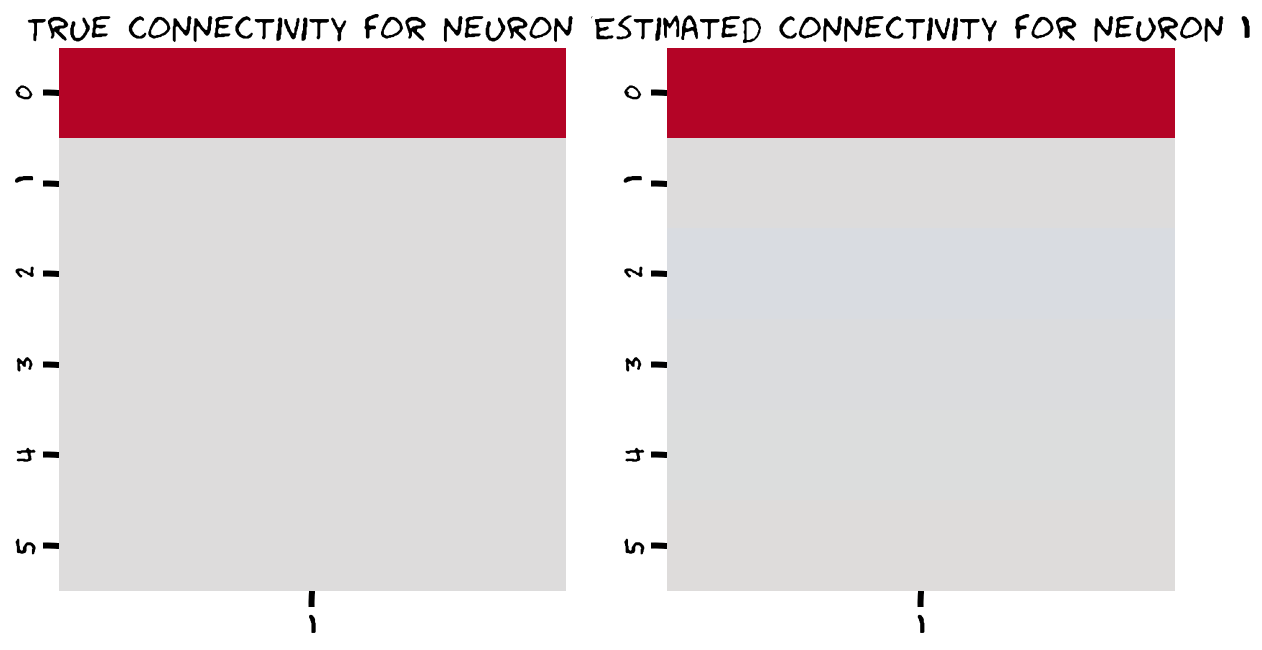

In [6]:
# to_remove solution
def compute_connectivity_single_neuron(X, selected_neuron):
    """
    Computes the connectivity matrix for a single neuron neurons using correlations

    Args:
        X: the matrix of activities
    Returns:
        estimated_connectivity (np.ndarray): estimated connectivity for the selected neuron, of shape (n_neurons,)
    """

    next_activity = X[selected_neuron, 1:] # extract the next activities of a neuron, t+1
    current_activity = X[:, :-1] # extract the current activity, t

    estimated_connectivity = np.zeros(n_neurons) # our stored estimated connectivity matrix

    for neuron_idx in range(n_neurons):
        this_input_activity = current_activity[neuron_idx]

        # solution
        correlation = np.corrcoef(this_input_activity, current_activity)[0,1]

        estimated_connectivity[neuron_idx] = correlation

    return estimated_connectivity

# Simulate a 6 neuron system for 5000 timesteps again.
n_neurons = 6
timesteps = 5000
A = create_connectivity(n_neurons)

X = simulate_neurons(A, timesteps)

estimated_connectivity = compute_connectivity_single_neuron(X,1)

with plt.xkcd():
    fig, axs = plt.subplots(1,2, figsize=(10,5)) 
    sns.heatmap(A[:, [1]], cbar=False, cmap="coolwarm", center=0, ax=axs[0])
    axs[0].set_xticklabels([1])
    axs[0].set_title("True connectivity for neuron 1")

    sns.heatmap(np.expand_dims(estimated_connectivity, axis=1), cbar=False, cmap="coolwarm", center=0, ax=axs[1])
    axs[1].set_xticklabels([1])
    axs[1].set_title("Estimated connectivity for neuron 1")
    plt.show()

## Visualization for all neurons

Hopefully you saw that it pretty much worked. We wrote a function that does what you just did but in matrix form, so it's a little faster. It also does all neurons at the same time. Run this cell to define that function.


In [7]:
#@title Correlation for all neurons function
def correlation_for_all_neurons(X):
  """Computes the connectivity matrix for the all neurons using correlations

    Args:
        X: the matrix of activities

    Returns:
        estimated_connectivity (np.ndarray): estimated connectivity for the selected neuron, of shape (n_neurons,)
        """
  n_neurons = len(X)
  S = np.concatenate([X[:, 1:], X[:, :-1]], axis=0)
  R = np.corrcoef(S)[:n_neurons, n_neurons:] 
  return R


Now let's estimate the whole connectivity. Run this:

Text(0.5, 1.0, 'Estimated connectivity matrix R')

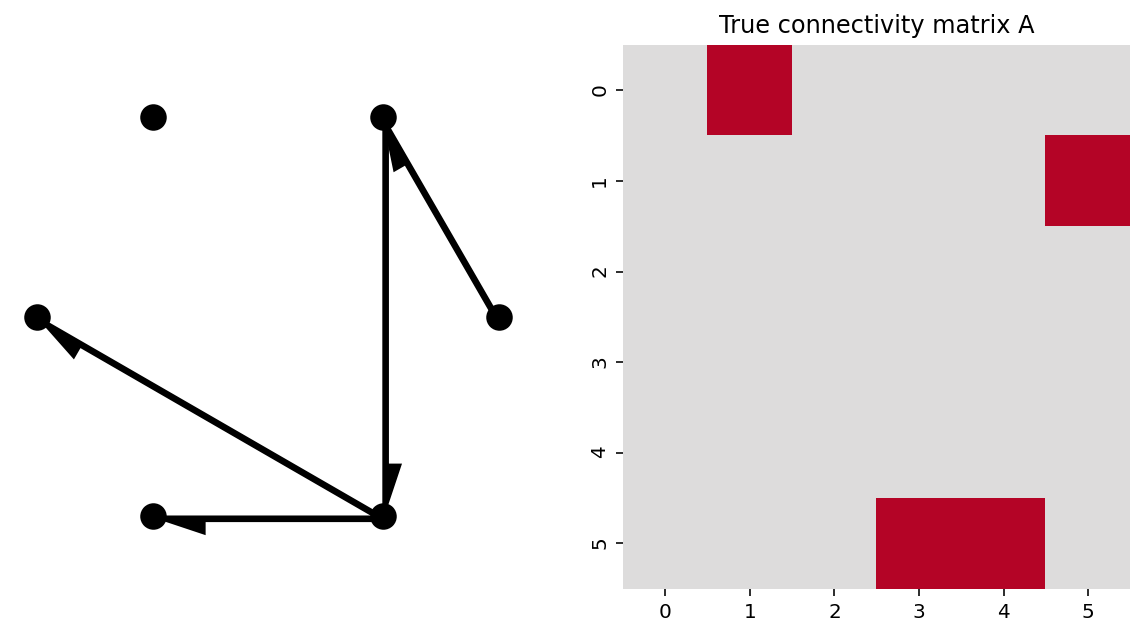

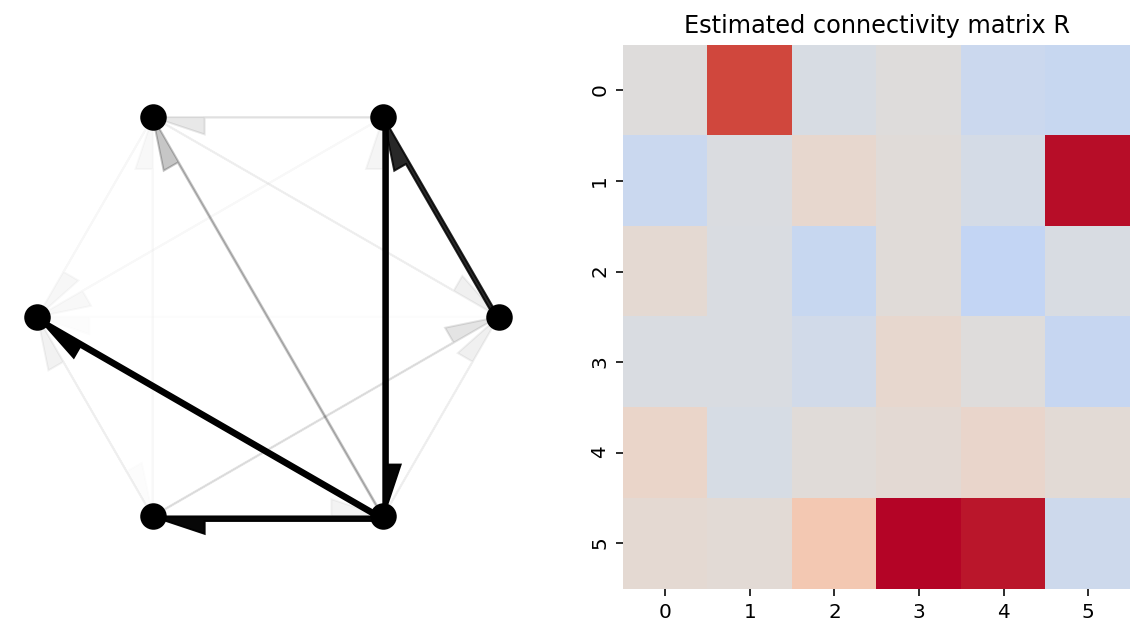

In [8]:
R = correlation_for_all_neurons(X)

fig, axs = plt.subplots(1,2, figsize=(10,5)) 
see_neurons(A,axs[0])
sns.heatmap(A,ax=axs[1], cmap="coolwarm",center=0, cbar=False)
plt.title("True connectivity matrix A")

fig, axs = plt.subplots(1,2, figsize=(10,5)) 
see_neurons(R,axs[0])
sns.heatmap(R,ax=axs[1], cmap="coolwarm",center=0,cbar=False)
plt.title("Estimated connectivity matrix R")

That pretty much worked too. Let's quantify how much it worked. 

We'll calculate the correlation coefficient between the true connectivity and the actual connectivity;

In [9]:
print("Correlation matrix of A and R:", np.corrcoef(A.flatten(), R.flatten())[0,1])

Correlation matrix of A and R: 0.9596667994046594


It *appears* in our system that correlation captures causality.

# Large systems

As our system becomes more complex however, correlation fails to capture causality.

Video available at https://youtu.be/Qd_tLRA2zxU


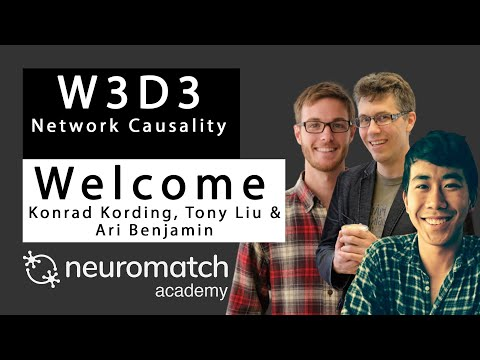

In [10]:
#@title Video 
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Qd_tLRA2zxU", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Failure of correlation in complex systems

Let's jump to a much bigger system. Instead of 6 neurons, we will now use 100 neurons. How does the estimation quality of the connectivity matrix change? 

In [11]:
# Simulate a 100 neuron system for 5000 timesteps.
n_neurons = 100
timesteps = 5000
random_state = 42

A = create_connectivity(n_neurons,random_state)
X = simulate_neurons(A, timesteps)
R = correlation_for_all_neurons(X)

np.corrcoef(A.flatten(), R.flatten())[0,1]

0.3629329824177816

Oh that's much worse.

Let's visualize the true vs estimated connectivity matrix for 100 neurons:

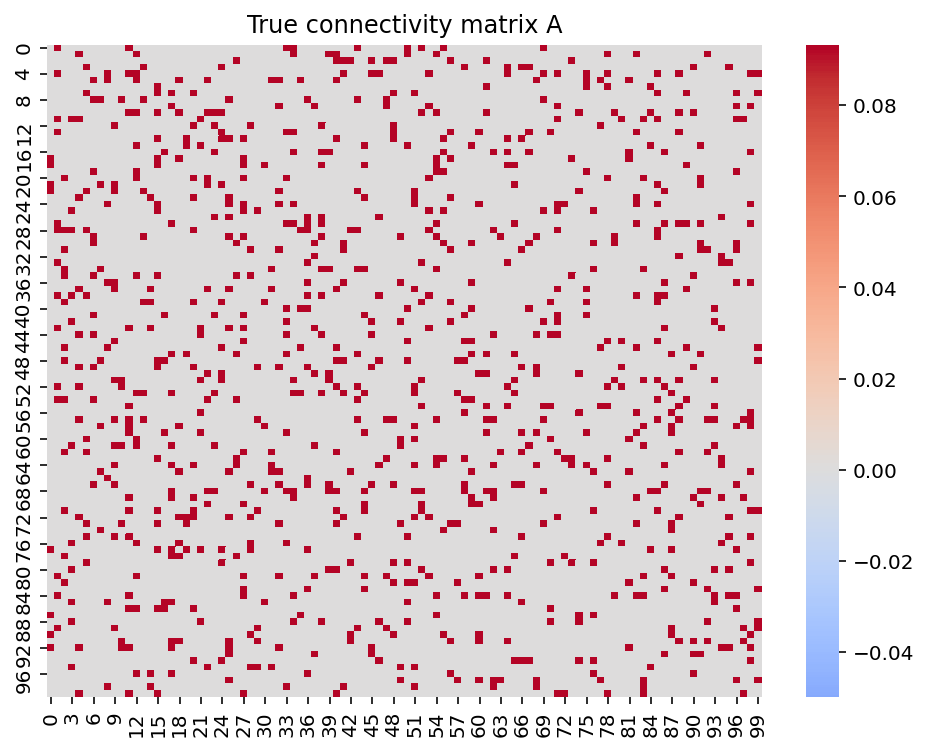

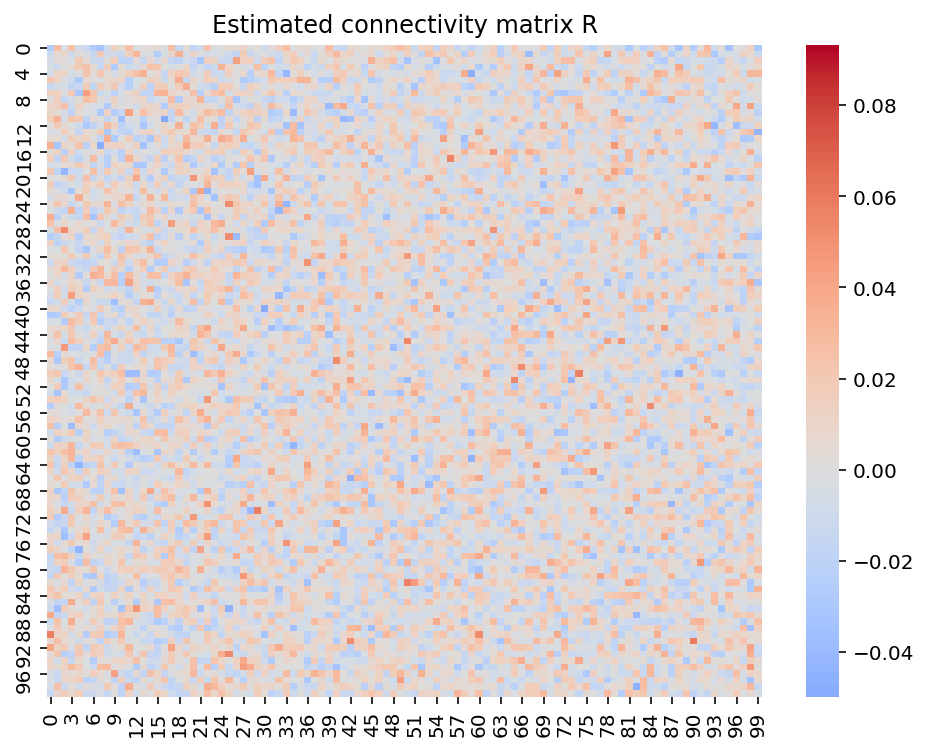

In [12]:
sns.heatmap(A, cmap="coolwarm", center=0, vmax=A.max(), vmin=R.min())
plt.title("True connectivity matrix A")
plt.show()
sns.heatmap(R, cmap="coolwarm", center=0, vmax=A.max(), vmin=R.min())
plt.title("Estimated connectivity matrix R")
plt.show()

## Correlation as a function of network size



Video available at https://youtu.be/xoKZW1PNp9k


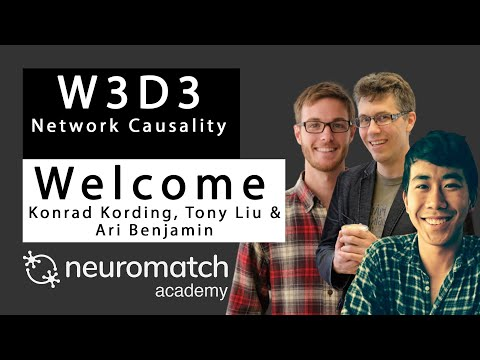

In [13]:
#@title Video 
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="xoKZW1PNp9k", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

### Exercise 2: Observing connectivity estimation with differing numbers of neurons

Instead of looking at just a few neurons (6) or a lot of neurons (100), as above, we will now systematically vary the number of neurons and plot the resulting changes in correlation coefficient between the true and estimated connectivity matrices. 

In [14]:
n_trials = 5
timesteps = 1000 # shorter timesteps for faster running time

#####################################################################################
## TODO: Choose five different number of neurons (between 1 and 100 for code speed)
#####################################################################################

number_of_neurons = [...]

# Uncomment the lines below to visualize correlation across network sizes, plot_estimation_quality
# is a helper function that estimates the connectivity matrix based on correlations for each system size
# and plots the resulting quality of estimation vs number of neurons
# plot_estimation_quality_vs_n_neurons(number_of_neurons) 


simulating trial 1 of 5
simulating trial 2 of 5
simulating trial 3 of 5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


simulating trial 4 of 5
simulating trial 5 of 5


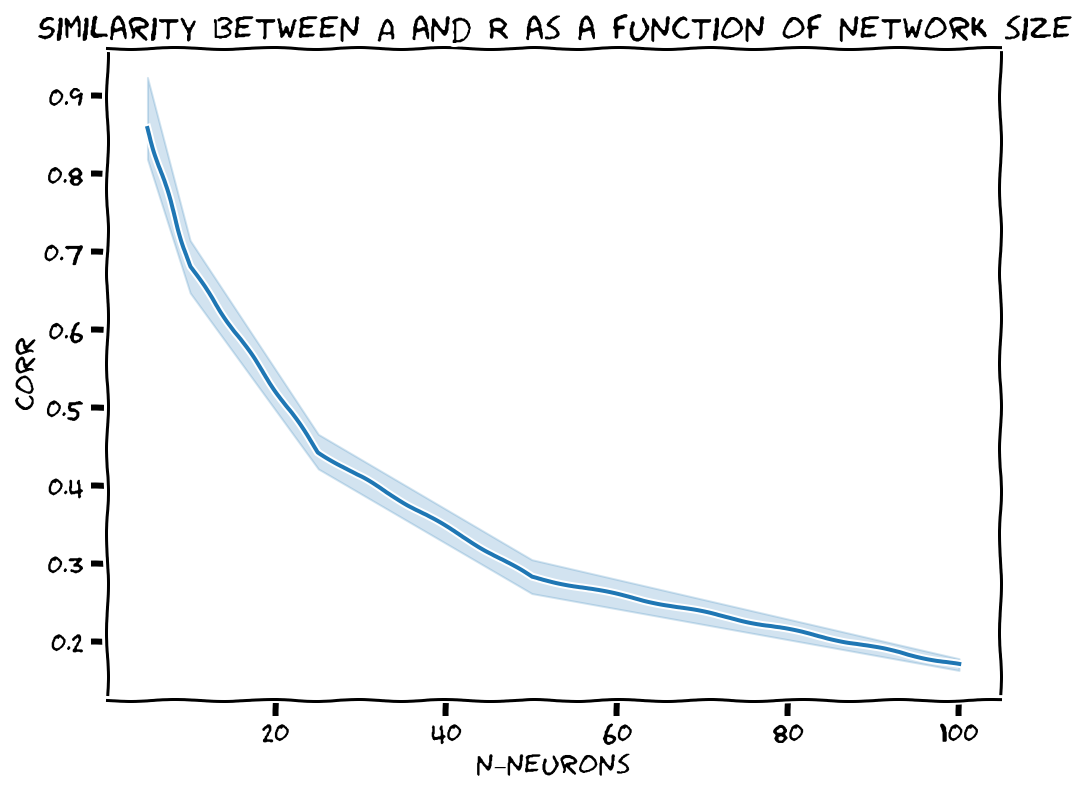

In [15]:
# to_remove solution
n_trials = 5
timesteps = 1000 # shorter timesteps for faster running time

# solution
number_of_neurons = [5, 10, 25, 50, 100]

with plt.xkcd():
  plot_estimation_quality_vs_n_neurons(number_of_neurons) 

Video available at https://youtu.be/0sRmNgyHtcs


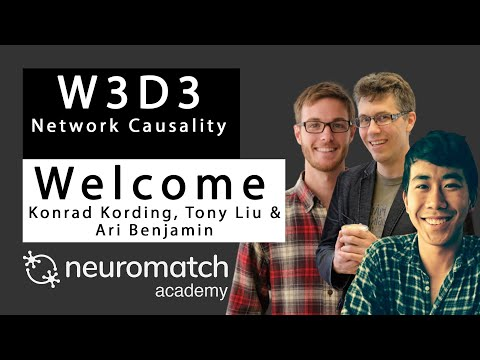

In [16]:
#@title Video 
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="0sRmNgyHtcs", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

# (Optional) Advanced section: an fMRI analogy

Please come back to this section only if you get through all the other material during tutorials (or later on your own)

A common situation in neuroscience is that you observe the *average* activity of large groups of neurons. (Think fMRI, EEG, LFP, etc.) We know deep down it's the neurons that are communicating, but perhaps we can learn something about the way areas or groups of neurons causally affect one another.

We're going to simulate this effect, and ask if correlations work to recover causal effects.

**Note on the quality of the analogy**: This is not intended as a perfect analogy of the brain or fMRI. Instead, we want to ask: *in a big system in which correlations fail to estimate causality, can you at least recover average connectivity?*

**Some brainy differences to remember**:
We are assuming that the connectivity is random. In real brains, the neurons that are averaged have correlated input and output connectivities. This will improve the correspondence between correlations and causailty for the average effect because the system is effectively smaller. However, in real brains the system is also order of magnitudes larger than what we examine here, and the experimenter never has the fully-observed system.

## Simulate a large system

Run this. It will take a bit so move on as it runs.


In [17]:
n_neurons = 256
timesteps = 10000
random_state = 42

A = create_connectivity(n_neurons,random_state)
X = simulate_neurons(A, timesteps)

## Coarsely sample the system

We don't observe this system. Instead, we observe the average activity of groups.


### Exercise 3 (Optional): Compute average activity across groups and compare resulting connectivity to the truth


Let's get a new matrix `coarse_X` that has 16 groups, each reflecting the average activity of 16 neurons.

We will then define the true coarse connectivity as the average of the neuronal connection strengths between groups. We'll then get the correlation between our coarsely sampled groups.


In [18]:
n_groups = 16

###################################################################
##  TODO: compute the coarse_X with the specified number of groups
##  Function hint: try using np.reshape()
###################################################################
# coarse_X = ...


# Uncomment these lines to visualize and compare our coarse samples to the truth
# assert coarse_X.shape == (n_groups, timesteps)
# R = correlation_for_all_neurons(coarse_X)
# coarse_A = A.reshape(n_groups, n_neurons//n_groups, n_groups, n_neurons//n_groups).mean(3).mean(1)


# fig, axs = plt.subplots(1,2, figsize=(10,5))
# sns.heatmap(coarse_A, ax=axs[0],cmap="coolwarm",center=0, cbar=False)
# sns.heatmap(R, ax=axs[1],cmap="coolwarm",center=0, cbar=False)
# axs[0].set_title("Coarse connectivity matrix")
# axs[1].set_title("Estimated coarse connectivity matrix")
# plt.show()
# print("Correlation: {}".format(np.corrcoef(coarse_A.flatten(), R.flatten())[0,1]))

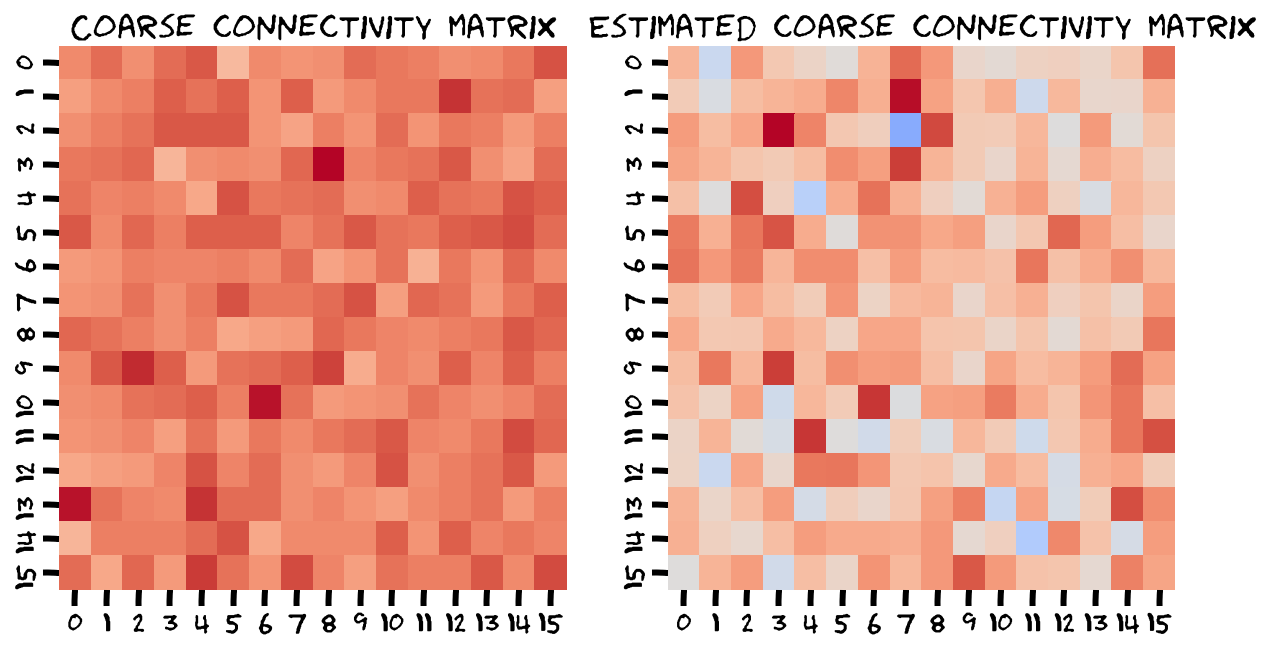

Correlation: 0.1871085307158572


In [19]:
# to_remove solution
n_groups = 16
coarse_X = X.reshape(n_groups, n_neurons//n_groups, timesteps).mean(1)

assert coarse_X.shape == (n_groups, timesteps)

R = correlation_for_all_neurons(coarse_X)
coarse_A = A.reshape(n_groups, n_neurons//n_groups, n_groups, n_neurons//n_groups).mean(3).mean(1)

with plt.xkcd():
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    sns.heatmap(coarse_A, ax=axs[0],cmap="coolwarm",center=0, cbar=False)
    sns.heatmap(R, ax=axs[1],cmap="coolwarm",center=0, cbar=False)
    axs[0].set_title("Coarse connectivity matrix")
    axs[1].set_title("Estimated coarse connectivity matrix")
    plt.show()
    print("Correlation: {}".format(np.corrcoef(coarse_A.flatten(), R.flatten())[0,1]))

How close is the estimated coarse connectivity matrix to the truth?

## Get performance as a function of how coarsely we sample

Write a function that wraps what we just did. It should return the correlation as a function of `n_groups`.

Then, plot the correlation as a function of the sampling ratio.

### Exercise 4 (Optional): Correlation across coarse sampling

In [20]:
def get_coarse_corr(n_groups, X):
    """
    A wrapper function for our correlation calculations between coarsely sampled
    A and R.

    Args:
        n_groups (int): the number of groups. should divide the number of neurons evenly
        X: the simulated system

    Returns:
        A single float correlation value representing the similarity between A and R
    """

    ############################################################################
    ## Insert your code here to get coarsely sampled X and A matrices with
    ## the corresponding R matrix and correlation.
    ## 
    ## The code below should be very similar to the coarsely sampled X you
    ## completed in Exercise 3 and the code we provided in the previous section 
    ## to compare sampling to the ground truth.

    # Fill out function then remove
    raise NotImplementedError('Compute correlations for a given coarseness')  
    ############################################################################
    coarse_X = ...
    R = ...
    coarse_A = ...
    corr = ...
    
    return corr

# uncomment to test your get_coarse_corr() function and visualize the 
# correlation between our coarsely sampled system.
# n_neurons = 128
# timesteps = 5000
# n_trials = 3

# df_dict = {
#     'trial': [],
#     'n_neurons': [],
#     'corr': []
# }

# for trial in range(n_trials):
#     print("Trial {} out of {}".format(trial, n_trials))
#     A = create_connectivity(n_neurons,random_state=trial)
#     X = simulate_neurons(A, timesteps, random_state=trial)
#     groups = [2**i for i in range(2,int(np.log2(n_neurons)))]
#     corrs = []
#     for n_groups in groups:
#         df_dict['n_neurons'].append(n_neurons/n_groups)
#         corr = get_coarse_corr(n_groups,X)
#         df_dict['corr'].append(corr)
#         df_dict['trial'].append(trial)
#         #corrs.append(get_coarse_corr(n_groups,X))

# coarse_df = pd.DataFrame.from_dict(df_dict)
# sns.lineplot(x="n_neurons", y="corr", data=coarse_df)
# plt.ylim([-0.2,1])
# plt.xlabel("Number of neurons per group (out of {} total)".format(n_neurons), 
#         fontsize=15)
# plt.ylabel("Correlation of estimated effective connectivity")
# plt.show()


Trial 0 out of 3
Trial 1 out of 3
Trial 2 out of 3


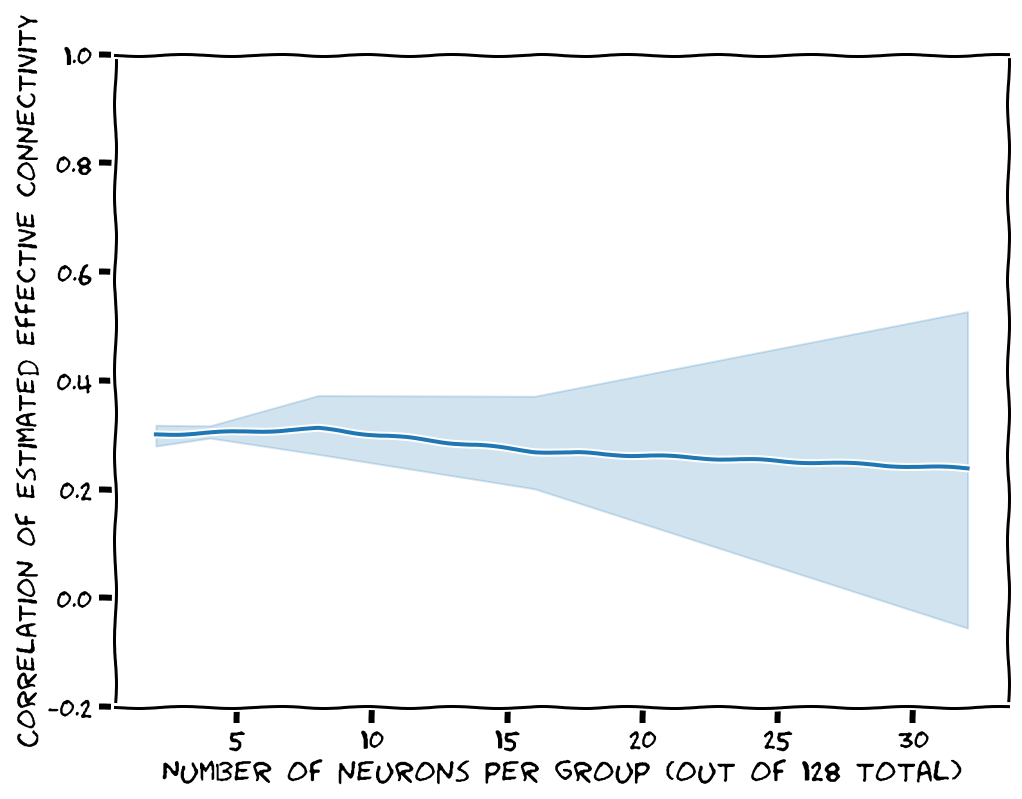

CPU times: user 42.5 s, sys: 19.8 s, total: 1min 2s
Wall time: 31.7 s


In [21]:
# to_remove solution
%%time
def get_coarse_corr(n_groups, X):
    """
    A wrapper function for our correlation calculations between coarsely sampled
    A and R.

    Args:
        n_groups (int): the number of groups. should divide the number of neurons evenly
        X: the simulated system

    Returns:
        A single float correlation value representing the similarity between A and R
    """
    
    # solution
    coarse_X = X.reshape(n_groups, n_neurons//n_groups, timesteps).mean(1)
    R = correlation_for_all_neurons(coarse_X)
    coarse_A = A.reshape(n_groups, n_neurons//n_groups, n_groups, n_neurons//n_groups).mean(3).mean(1)
    corr = np.corrcoef(coarse_A.flatten(), R.flatten())[0,1]

    return corr

n_neurons = 128
timesteps = 5000
n_trials = 3

df_dict = {
    'trial': [],
    'n_neurons': [],
    'corr': []
}

for trial in range(n_trials):
    print("Trial {} out of {}".format(trial, n_trials))
    A = create_connectivity(n_neurons,random_state=trial)
    X = simulate_neurons(A, timesteps, random_state=trial)
    groups = [2**i for i in range(2,int(np.log2(n_neurons)))]
    corrs = []
    for n_groups in groups:
        df_dict['n_neurons'].append(n_neurons/n_groups)
        corr = get_coarse_corr(n_groups,X)
        df_dict['corr'].append(corr)
        df_dict['trial'].append(trial)
        #corrs.append(get_coarse_corr(n_groups,X))

coarse_df = pd.DataFrame.from_dict(df_dict)
with plt.xkcd():
    sns.lineplot(x="n_neurons", y="corr", data=coarse_df)
    plt.ylim([-0.2,1])
    plt.xlabel("Number of neurons per group (out of {} total)".format(n_neurons), 
            fontsize=15)
    plt.ylabel("Correlation of estimated effective connectivity")
    plt.show()

## Summary

Now for the takeaway. We know that for large systems correlation ≠ causation. But what about when we coarsely sample the large system? Do we get better at estimating the *effective* causal interaction between groups (=average of weights) from the correlation between the groups?

From our simulation above, the answer appears to be no: as the number of neurons per group increases, we don't see any significant increase in our ability to estimate the causal interaction between groups.

# Appendix



## Correlation as similarity metric

We'd like to note here that though we make use of Pearson correlation coefficients throughout all of our tutorials to measure similarity between our estimated connectivity matrix $R$ and the ground truth connectivity $A$, this is not strictly correct usage of Pearson correlations as elements of $A$ are not normally distributed (they are in fact binary).

We use Pearson correlations as they are quick and easy to compute within the Numpy framework and provide qualitatively similar results to other correlation metrics. Other ways to compute similarities:
- [Spearman rank correlations](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient), which does not require normally distributed data
- dichotomizing our estimated matrix $R$ by the median and then running concordance analysis, such as computing [Cohen's kappa](https://en.wikipedia.org/wiki/Cohen%27s_kappa)

Another thing to consider: all we want is some measure of the similarity between $A$ and $R$. Element-wise comparisons are one way to do this, but are there other ways you can think of? What about matrix similarities?

